# Обучение ResNet-20

In [1]:
!git clone https://github.com/davdevv/ResNet_20_Pruning.git

Cloning into 'ResNet_20_Pruning'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 76 (delta 27), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (76/76), 2.88 MiB | 3.51 MiB/s, done.


In [2]:
import torch
from ResNet_20_Pruning.data.cifar10 import Cifar10
from ResNet_20_Pruning.models.resnet import resnet20
from ResNet_20_Pruning.train import train, validate

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 100
batch_size = 128
lr = 1e-3
weight_decay = 1e-4
threads = 2
label_smoothing = 0.1
use_autoaugment, use_cutout = True, True

dataset = Cifar10(batch_size, use_autoaugment, use_cutout, threads=threads)
num_classes = dataset.num_classes
resnet20_model = resnet20()
resnet20_model.to(device);

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


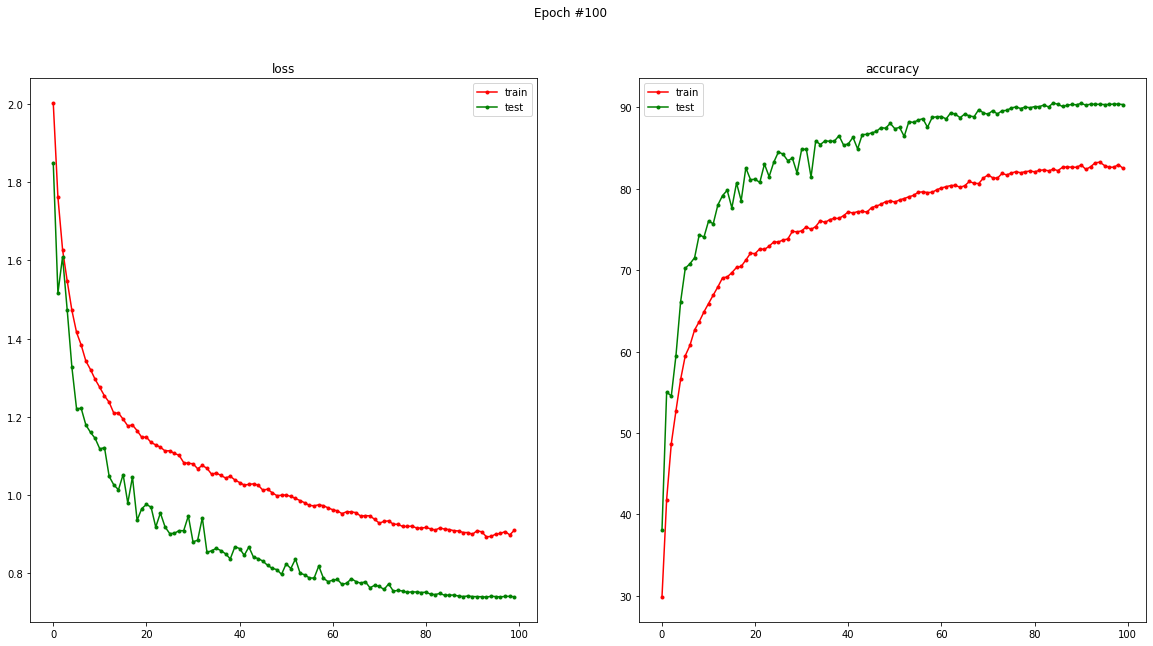

In [5]:
optimizer = torch.optim.Adam(resnet20_model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
train(optimizer, scheduler, resnet20_model, dataset, num_epochs, label_smoothing=label_smoothing, device=device)

# Инференс

Я загрузил обученную модель на гугл-диск.

In [4]:
!gdown 1RV4Fa-BXSUDErStnSwY_47cRdA9yfQj2

Downloading...
From: https://drive.google.com/uc?id=1RV4Fa-BXSUDErStnSwY_47cRdA9yfQj2
To: /content/best_test_acc.pth
100% 3.33M/3.33M [00:00<00:00, 229MB/s]


In [5]:
checkpoint = torch.load('/content/best_test_acc.pth')
resnet20_model.load_state_dict(checkpoint['model_state_dict'])
_, acc = validate(dataset, resnet20_model, label_smoothing, device)
print('Accuracy on test data: {:.3f}%'.format(acc))

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy on test data: 90.710%


Как видим, получили >90% на тесте.

# Filter-level Pruning

Cуть filter-level прунинга такова: 


1.   Мы обучили модель и получили приемлимое качество предсказания. Теперь мы хотим ее сжать, т. е. уменьшить расход памяти, а также уменьшить вычислительную сложность. Это происходит за счет устранения части параметров в предобученной модели. Цель при этом - не потерять существенно в качестве.

2.  Для этого рассматриваются сверточные слои и сверточные фильтры. Для каждого набора фильтров производится кластеризация. А именно: каждая исходная свертка в определенном слое заменяется на центроид кластера, к которому она была отнесена алгоритмом кластеризации. 

3. Опционально можно сделать следующее: дообучить модель с новыми весами на нескольких эпохах. Это должно улучшить точность.








Я реализовал предложенный метод прунинга.

In [6]:
from ResNet_20_Pruning.pruning import cluster_conv_net

Для начала проверим работает ли. В качестве числа кластеров будем передовать реальное количество фильтров на каждом слое. 

clust_dict - это словарь, ключи которого являются номером сверточного слоя, а значения числом кластеров/центроидов.

In [7]:
clust_dict = {1: 16, 2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 16, 8: 32, 9: 32, 10: 32,
              11: 32, 12: 32, 13: 32, 14: 64, 15: 64, 16: 64, 17: 64, 18: 64, 19: 64}
_, acc = validate(dataset, cluster_conv_net(resnet20_model, clust_dict, device).to(device), label_smoothing, device);
print('Accuracy on test data: {:.3f}%'.format(acc));

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy on test data: 90.710%


Все в порядке, аccuracy осталось прежним. 

Теперь попробуем использовать одинаковое число кластеров для каждого слоя.

In [8]:
clust_dict = {1: 16, 2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 16, 8: 16, 9: 16, 10: 16,
              11: 16, 12: 16, 13: 16, 14: 16, 15: 16, 16: 16, 17: 16, 18: 16, 19: 16}
_, acc = validate(dataset, cluster_conv_net(resnet20_model, clust_dict, device).to(device), label_smoothing, device);
print('Accuracy on test data: {:.3f}%'.format(acc));

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy on test data: 15.690%


Видно, что при одинаковом количестве кластеров на каждом слое точность полученной модели очень низкая.

Попробуем не трогать последние слои, а на первых сделать число кластеров в два раза меньше числа фильтров. 

In [9]:
clust_dict = {1: 8, 2: 8, 3: 8, 4: 8, 5: 8, 6: 8, 7: 8, 8: 16, 9: 16, 10: 16,
              11: 16, 12: 16, 13: 16, 14: 64, 15: 64, 16: 64, 17: 64, 18: 64, 19: 64}
first_layers_clust = cluster_conv_net(resnet20_model, clust_dict, device).to(device)
_, acc = validate(dataset, first_layers_clust, label_smoothing, device);
print('Accuracy on test data: {:.3f}%'.format(acc));

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy on test data: 15.670%


Точность очень низкая.

Теперь наоборот. Попробуем для последних слоев использовать меньше кластеров чем на всех остальных.

In [10]:
clust_dict = {1: 16, 2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 16, 8: 32, 9: 32, 10: 32,
              11: 32, 12: 32, 13: 32, 14: 32, 15: 32, 16: 32, 17: 32, 18: 32, 19: 32}
last_layers_clust = cluster_conv_net(resnet20_model, clust_dict, device).to(device)
_, acc = validate(dataset, last_layers_clust, label_smoothing, device);
print('Accuracy on test data: {:.3f}%'.format(acc));

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy on test data: 43.800%


Точность стала получше. Однако все еще достаточно низкая, с учетом того, что затронуто было только 6 последних слоев.

Попробуем доучить модель first_layers_clust, у которой мы кластеризовали первые два блока, а последний не трогали. Заморозим кластеризованные блоки и будем обучать только последний.




In [11]:
for p in first_layers_clust.layer1.parameters(): 
  p.requires_grad = False

for p in first_layers_clust.layer2.parameters(): 
  p.requires_grad = False

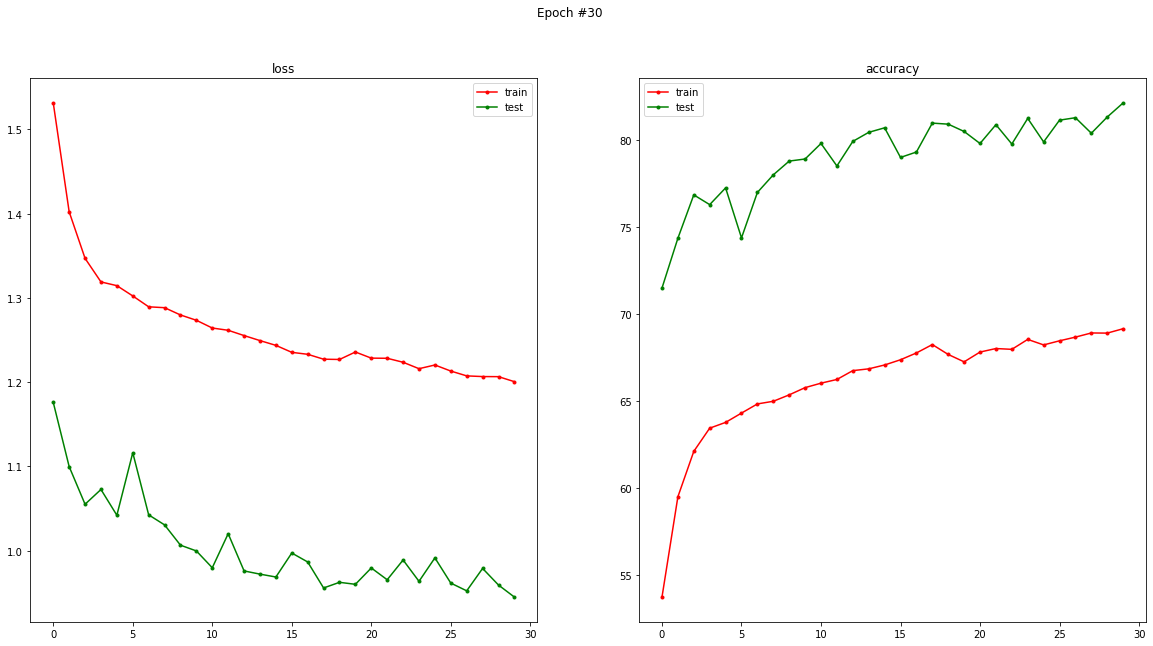

In [12]:
optimizer = torch.optim.Adam(first_layers_clust.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)
train(optimizer, scheduler, first_layers_clust, dataset, 30, label_smoothing=label_smoothing, device=device)

In [13]:
_, acc = validate(dataset, first_layers_clust, label_smoothing, device)
print('Accuracy on test data: {:.3f}%'.format(acc))

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy on test data: 82.120%


#Анализ результатов и идеи

Ясно, что подход кластеризации фильтров с последующей их заменой на центроиды кластеров помогает облегчить модель, поскольку достаточно хранить только центроиды для дальнейшей инициализации ими модели. Однако качество предсказаний значительно понижается.

Однако, дообучение действительно позволяет значительно улучшить точность модели. Правда при этом кластеризованными остается только часть сверточных слоев, что несколько уменьшает выгоду по памяти. Accuracy не достигает показателя некластеризованной модели (90.71 vs 82.12), но уже не так плох. Я думаю поэксперементировав со scheduler, числом эпох и другими гиперпараметрами, можно сравняться по точности.

Первой идеей, которую стоит проверить на мой взгляд, это дообучать особым способом. А именно, вычислять средний градиент по весам, относящимся к одному кластеру и делать по нему update. Тем самым сохранится структура, веса не "разбегутся" и выгода с точки зрения памяти останется.

Следующей идеей является простое эксперементирование с кластеризацией. Например: попробовать иные алгоритмы кластеризации; заменять не на центроид, а на одного из представителей; рассмотреть косинусное расстояние в иерархической класетризации. А еще можно попробовать искать кластеры внутри фильтра.

Также я бы хотел поделиться статьями, которые просмотрел, когда изучал тему вокруг прунинга.

[Filter Pruning via Geometric Median for Deep Convolutional Neural Networks Acceleration.](https://arxiv.org/abs/1811.00250) Классические методы прунинга отбрасывают веса с наименьшей нормой. Но у этого подхода много недостатков (нужны большие разбросы весов и непонятно, что делать, если минимальные по норме фильтры все равно большие по абсолютным значениям). В этой работе предлагается альтернативный способ прореживания: выкидывать медианные фильтры, которы минимизируют сумму абсолютных отклонений. FPGM метод отлично показал себя в уменьшении FLOPs и в сохранении точности.

[HRank: Filter Pruning using High-Rank Feature Map.](https://arxiv.org/pdf/2002.10179.pdf) Авторы это статьи заметили, что средний ранг у feature map, который был получен одним фильтром, не меняется независимо от числа картинок, которые подаются на вход. Кроме того, веса у мало-ранговых feature map содержат мало информации, то есть от них можно избавиться без большой потери в качестве. И на этом основан их метод прунинга. Стоит отметить, что без всякого дообучения, получается добиться для ResNet-110 уменьшения FLOPs на 58% при падении top-1 точности на 0.14% на CIFAR-10














